# 1. Responses collection/ inference on example data

## Example data

In [67]:
import jsonlines
import json
import numpy as np
import os
from scripts.utils import load_jsonlines

# path = '/home/minqi/code/S2RAG/data_eval/arc_challenge_processed.jsonl'
path = '/home/minqi/code/S2RAG/data_eval/popqa_longtail_w_gs.jsonl'
outpath = path.split('.jsonl')[0] + '_example.jsonl'

data = load_jsonlines(path)
# sample 100 data as example
new_data = data[:100]
print(len(new_data))
print(new_data[0])

with open(outpath, 'w') as f:
    for item in new_data:
        json.dump(item, f)
        f.write('\n')

100
{'question': "What is Henry Feilden's occupation?", 'answers': ['politician', 'political leader', 'political figure', 'polit.', 'pol'], 'prop': 'occupation', 's_wiki_title': 'Henry Feilden (Conservative politician)', 'id': 4382392, 'pop': 58, 'ctxs': [{'id': '11341299', 'title': 'Henry Feilden (Conservative politician)', 'text': ' Henry Master Feilden (21 February 1818 – 5 September 1875) was an English Conservative Party politician.', 'score': '1.6985543'}, {'id': '3064835', 'title': 'Feilden', 'text': 'Bernard Feilden (1919–2008), British conservation architect ; Bob Feilden (1917–2004), British mechanical engineer ; Gerry Feilden (1904–1981), British general and horse racing identity ; Henry Feilden (disambiguation) ; Joseph Feilden (1824–1895), British politician ; Richard Feilden (1950–2005), British architect ; William Feilden (1772–1850), British politician ', 'score': '1.5850108'}, {'id': '14189134', 'title': 'Feilden baronets', 'text': ' Henry Wemyss Feilden, second son of

## check output format

In [30]:
result_path = '/home/minqi/code/S2RAG/minqi_inf_output/llama2chat-arc-origin.json'

with open(result_path, 'r') as f:
    result = json.load(f)

result = result['results']

print(result[0].keys())
print(result[0]['gold'])
print(result[0]['retrieval_res'])
print('='*100)
print(result[0]['retrieval_res']['retrieval_0']['pred'])

dict_keys(['prompts', 'no_retrieval', 'no_retrieval_ids', 'no_retrieval_log_probs', 'all_doc_retrieval', 'all_doc_retrieval_ids', 'all_doc_retrieval_log_probs', 'retrieval_res', 'question_id', 'gold'])
['C']
{'retrieval_0': {'pred': '(C) Planetary days will become shorter.\n\nThe rotation of a planet induces a', 'score': 0.8261348109707755, 'id_log_probs': [-0.2086123526096344, -0.021632548421621323, -0.4886851906776428, -0.00014256415306590497, 0.0, -4.577531944960356e-05, -2.145764938177308e-06, -7.510157047363464e-06, -8.320462075062096e-05, -0.00035661060246638954, -0.011544683948159218, -0.00031513971043750644, -1.0318551063537598, -0.8292770981788635, -0.6933400630950928, -0.0009232072625309229, -5.8412379075889476e-06, -0.4627149999141693, -8.344646857949556e-07, -0.07040131092071533], 'token_ids': [313, 29907, 29897, 20540, 653, 3841, 674, 4953, 20511, 29889, 13, 13, 1576, 13733, 310, 263, 15754, 9013, 778, 263], 'evidence': {'id': '501031', 'title': 'Rotation', 'text': 'all sp

# 2. Adaptive Retrieval Analysis on example data

This part is co-written by:

Contributors:
- Minqi Xiang (mx716@ic.ac.uk) Equally contributed
- Zihan Zhu (zcabhub@ucl.ac.uk) Equally contributed

Public Source: https://github.com/zhuzihan728/LLM_Adaptive_RAG
Private Source: https://github.com/minqi1/S2RAG

In [31]:
from scripts.metrics import *
from sklearn.metrics import accuracy_score, log_loss
import json

def adp_ret_analysis(file_name, ret_p, task, model_name, interval=0.01):
    if 'health' in file_name or 'arc' in file_name:
        metric = loose_acc
    else:
        metric = loose_match
    acc_point5 = 0
    rf_point5 = 0
    labels = []

    # load data
    res_dc = []
    with open(file_name) as f:
        original_data = json.load(f)

        if type(original_data) == list:
            res_dc = original_data
        else:
            res_dc = original_data['results']

    for data_res in res_dc:
        if metric_max_over_ground_truths(metric, data_res['no_retrieval'], data_res['gold']) > 0:
            no_ret_acc = 1
        else:
            no_ret_acc = 0
        hit = 0
        for i in range(5):
            if metric_max_over_ground_truths(metric, data_res["retrieval_res"][f'retrieval_{i}']['pred'], data_res['gold']) > 0:
                hit = 1
                break
        ret_acc = hit
        if no_ret_acc > 0:
            labels.append(0)
        else:   
            labels.append(1)
        
    draw_dc = {"retrieval threshold":[], "retrieval freq":[], "self-adaptive acc":[]}
    for thres in [round(interval*i,2) for i in range(0, int(1/interval)+1)]:
        retrieval_freq = np.sum((np.array(ret_p) - thres) > 0) / len(ret_p)
        preds = (np.array(ret_p) - thres) > 0

        selfadptive_acc = accuracy_score(labels, preds)
        if abs(thres - 0.5) < 1e-5:
            rf_point5 = round(retrieval_freq*100,1)
            print(f"thres: {thres}, retrieval_freq: {rf_point5}%, selfadptive_acc: {round(selfadptive_acc,2)}")
        draw_dc["retrieval threshold"].append(thres)
        draw_dc["retrieval freq"].append(retrieval_freq)
        draw_dc["self-adaptive acc"].append(selfadptive_acc)
    
    draw_dc_ = {}
    draw_dc_["retrieval threshold"] = draw_dc["retrieval threshold"] + draw_dc["retrieval threshold"]
    draw_dc_['metric'] = ['retrieval freq']*len(draw_dc["retrieval freq"]) + ['self-adaptive acc']*len(draw_dc["self-adaptive acc"])
    draw_dc_['value'] = draw_dc["retrieval freq"] + draw_dc["self-adaptive acc"]
    draw_dc_['title'] = [f"{model_name} on {task}"]*len(draw_dc_['value'])

    return draw_dc_

In [32]:
files_dc = {
'/home/minqi/code/S2RAG/minqi_inf_output/llama2chat-arc-origin.json': '/home/minqi/code/S2RAG/minqi_inf_output/llama2chat-arc-selfadp.json'
}

out_dcs = []
successful_judgement_2_7 = []
successful_judgement_3 = []
successful_judgement_selfrag = []

for k, v in files_dc.items():
    paths = [v]
    for ret_p_path in paths:
        with open(ret_p_path, 'r') as f:
            ret_p_file = json.load(f)
            ret_p = ret_p_file["retrieval_p"]
            ret_p_hard = ret_p_file["retrieval_p_hard"]
        path = k

        successful_judgement = ret_p_file['has_judgment']
        if 'llama2chat-' in k:
            successful_judgement_2_7.extend(successful_judgement)
            model_name = 'llama2chat'
        elif 'llama3' in k:
            successful_judgement_3.extend(successful_judgement)
            model_name = 'llama3Ins'
        else:
            successful_judgement_selfrag.extend(successful_judgement)
            model_name = 'selfrag'

        task = k.split('-')[-1].split('.')[0] # ['pqa', 'tqa', 'health', 'arc']
        print(f"processing {task}, {model_name}")
        successful_judgement_rate = np.sum(successful_judgement) / len(successful_judgement)
        print(f"successful_judgement_rate: {successful_judgement_rate}")
        out_dc = adp_ret_analysis(k, ret_p, task, model_name, interval=0.01)
        out_dcs.append(out_dc)
    # plt.show()
print('===finished===')
print("successful_judgement_2_7", np.sum(successful_judgement_2_7) / len(successful_judgement_2_7))
# print("successful_judgement_3", np.sum(successful_judgement_3) / len(successful_judgement_3))
# print("successful_judgement_selfrag", np.sum(successful_judgement_selfrag) / len(successful_judgement_selfrag))


processing origin, llama2chat
successful_judgement_rate: 1.0
thres: 0.5, retrieval_freq: 100.0%, selfadptive_acc: 0.49
===finished===
successful_judgement_2_7 1.0


Text(0.5, 0.98, 'Self-adaptive retrieval analysis')

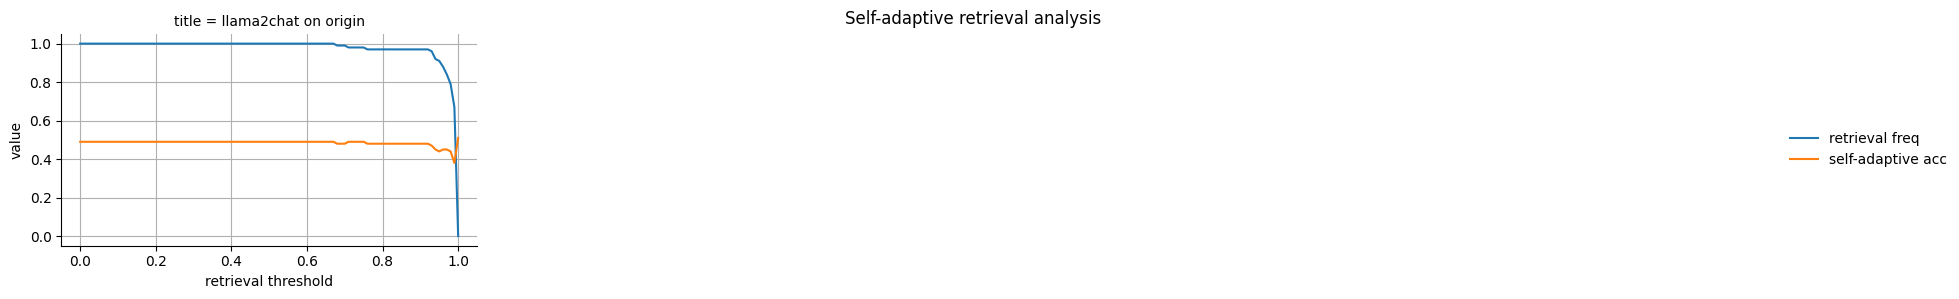

In [33]:
import pandas as pd
import seaborn as sns

final_dc = {"retrieval threshold":[], "value":[], "title":[], "metric":[]}

for dc in out_dcs:
    for k, v in dc.items():
        try:
            final_dc[k] += v
        except:
            pass

df = pd.DataFrame(final_dc)

filtered_df = df[df['metric'].isin(['self-adaptive acc', 'retrieval freq'])]

g = sns.FacetGrid(filtered_df, col="title", col_wrap=4, height=3, aspect=1.5)
g.map(sns.lineplot, "retrieval threshold", "value", hue="metric", data=df, sort=False,  errorbar=None, )

g.add_legend()

for ax in g.axes.flat:
    ax.grid(True)
    
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"Self-adaptive retrieval analysis")

### change data format for later process

In [34]:
result_path = '/home/minqi/code/S2RAG/minqi_inf_output/llama2chat-arc-origin.json'

with open(result_path, 'r') as f:
    json_file = json.load(f)
df1 = pd.DataFrame(json_file)

print(result[0].keys())
print(result[0]['gold'])
print(result[0]['retrieval_res'])
print('='*100)
print(result[0]['retrieval_res']['retrieval_0']['pred'])

dict_keys(['prompts', 'no_retrieval', 'no_retrieval_ids', 'no_retrieval_log_probs', 'all_doc_retrieval', 'all_doc_retrieval_ids', 'all_doc_retrieval_log_probs', 'retrieval_res', 'question_id', 'gold'])
['C']
{'retrieval_0': {'pred': '(C) Planetary days will become shorter.\n\nThe rotation of a planet induces a', 'score': 0.8261348109707755, 'id_log_probs': [-0.2086123526096344, -0.021632548421621323, -0.4886851906776428, -0.00014256415306590497, 0.0, -4.577531944960356e-05, -2.145764938177308e-06, -7.510157047363464e-06, -8.320462075062096e-05, -0.00035661060246638954, -0.011544683948159218, -0.00031513971043750644, -1.0318551063537598, -0.8292770981788635, -0.6933400630950928, -0.0009232072625309229, -5.8412379075889476e-06, -0.4627149999141693, -8.344646857949556e-07, -0.07040131092071533], 'token_ids': [313, 29907, 29897, 20540, 653, 3841, 674, 4953, 20511, 29889, 13, 13, 1576, 13733, 310, 263, 15754, 9013, 778, 263], 'evidence': {'id': '501031', 'title': 'Rotation', 'text': 'all sp

In [38]:
keys = ['no_retrieval', 'no_retrieval_ids', 'no_retrieval_log_probs',
       'all_doc_retrieval', 'all_doc_retrieval_ids',
       'all_doc_retrieval_log_probs', 'retrieval_res', 'question_id', 'gold',
       'question', 'ret_0', 'ret_0_log_probs', 'ret_0_ctx', 'ret_0_ctx_score',
       'ret_0_scores', 'ret_1', 'ret_1_log_probs', 'ret_1_ctx',
       'ret_1_ctx_score', 'ret_1_scores', 'ret_2', 'ret_2_log_probs',
       'ret_2_ctx', 'ret_2_ctx_score', 'ret_2_scores', 'ret_3',
       'ret_3_log_probs', 'ret_3_ctx', 'ret_3_ctx_score', 'ret_3_scores',
       'ret_4', 'ret_4_log_probs', 'ret_4_ctx', 'ret_4_ctx_score',
       'ret_4_scores']

result = {key: [] for key in keys}
for i in range(len(df1)):
    result['no_retrieval'].append(df1['results'][i]['no_retrieval'])
    result['no_retrieval_ids'].append(df1['results'][i]['no_retrieval_ids'])  
    result['no_retrieval_log_probs'].append(df1['results'][i]['no_retrieval_log_probs'])
    result['all_doc_retrieval'].append(df1['results'][i]['all_doc_retrieval'])
    result['all_doc_retrieval_ids'].append(df1['results'][i]['all_doc_retrieval_ids'])
    result['all_doc_retrieval_log_probs'].append(df1['results'][i]['all_doc_retrieval_log_probs'])
    # result['retrieval'].append(df1['results'][i]['retrieval'])
    # result['retrieval_token_ids'].append(df1['results'][i]['retrieval_token_ids'])
    # result['retrieval_log_probs'].append(df1['results'][i]['retrieval_log_probs'])
    result['retrieval_res'].append(df1['results'][i]['retrieval_res'])
    result['question_id'].append(df1['results'][i]['question_id'])
    result['gold'].append(df1['results'][i]['gold'])
    result['question'].append(df1['results'][i]['prompts']['no_retrieval'][0].replace('[INST]', '').replace('[/INST]', '').replace('<s>', '').replace('</s>', '').strip())
    
    result['ret_0'].append(df1['results'][i]['retrieval_res']['retrieval_0']['pred'])
    result['ret_0_log_probs'].append(df1['results'][i]['retrieval_res']['retrieval_0']['id_log_probs'])
    ret_0_evid = df1['results'][i]['retrieval_res']['retrieval_0']['evidence']
    result['ret_0_ctx'].append(ret_0_evid['title'] + '\n' + ret_0_evid['text'])
    result['ret_0_ctx_score'].append(ret_0_evid['score'])
    result['ret_0_scores'].append(None)
    
    result['ret_1'].append(df1['results'][i]['retrieval_res']['retrieval_1']['pred'])
    result['ret_1_log_probs'].append(df1['results'][i]['retrieval_res']['retrieval_1']['id_log_probs'])
    ret_1_evid = df1['results'][i]['retrieval_res']['retrieval_1']['evidence']
    result['ret_1_ctx'].append(ret_1_evid['title'] + '\n' + ret_1_evid['text'])
    result['ret_1_ctx_score'].append(ret_1_evid['score'])
    result['ret_1_scores'].append(None)

    result['ret_2'].append(df1['results'][i]['retrieval_res']['retrieval_2']['pred'])
    result['ret_2_log_probs'].append(df1['results'][i]['retrieval_res']['retrieval_2']['id_log_probs'])
    ret_2_evid = df1['results'][i]['retrieval_res']['retrieval_2']['evidence']
    result['ret_2_ctx'].append(ret_2_evid['title'] + '\n' + ret_2_evid['text'])
    result['ret_2_ctx_score'].append(ret_2_evid['score'])
    result['ret_2_scores'].append(None)

    result['ret_3'].append(df1['results'][i]['retrieval_res']['retrieval_3']['pred'])
    result['ret_3_log_probs'].append(df1['results'][i]['retrieval_res']['retrieval_3']['id_log_probs'])
    ret_3_evid = df1['results'][i]['retrieval_res']['retrieval_3']['evidence']
    result['ret_3_ctx'].append(ret_3_evid['title'] + '\n' + ret_3_evid['text'])
    result['ret_3_ctx_score'].append(ret_3_evid['score'])
    result['ret_3_scores'].append(None)

    result['ret_4'].append(df1['results'][i]['retrieval_res']['retrieval_4']['pred'])
    result['ret_4_log_probs'].append(df1['results'][i]['retrieval_res']['retrieval_4']['id_log_probs'])
    ret_4_evid = df1['results'][i]['retrieval_res']['retrieval_4']['evidence']
    result['ret_4_ctx'].append(ret_4_evid['title'] + '\n' + ret_4_evid['text'])
    result['ret_4_ctx_score'].append(ret_4_evid['score'])
    result['ret_4_scores'].append(None)
    
# convert dict of list to list of dict
list_of_dict = []

keys = result.keys()
length = len(result['no_retrieval'])
print(length)
for i in range(length):
    new_dict = {}
    for key in keys:
        new_dict[key] = result[key][i]
    list_of_dict.append(new_dict)

100


In [39]:
# output the results
output_path = result_path.replace('-origin.json', '.json')
with open(output_path, 'w') as f:
    json.dump(list_of_dict, f)

# 3. Confidence RAG analysis on example data

In [59]:
# simple calculation on the accuracy
import json
import pandas as pd
model = 'llama2-7b' # 'llama2-7b' or 'llama3-8b'
choice = 3

tasks = ['pqa', 'tqa', 'health', 'arc']
if 'llama2' in model and '7' in model:
    path = f'/home/minqi/code/S2RAG/minqi_inf_output/llama2chat-{tasks[choice]}.json'
elif 'llama3' in model:
    path = f'/home/minqi/code/S2RAG/minqi_inf_output/llama3Ins-{tasks[choice]}.json'
elif 'selfrag' in model:
    path = f'/home/minqi/code/S2RAG/minqi_inf_output/selfrag-{tasks[choice]}.json'

with open(path) as f:
    json_file = json.load(f)

df = pd.DataFrame(json_file)

metrics

In [60]:
def compute_confidence(log_probs):
    '''
    log_probs: List[float]
    '''
    return np.mean(np.exp(log_probs))

prefix = ['no_retrieval', 'ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']
answers = []
for item in json_file:
    cfd = [compute_confidence(item[pre + '_log_probs']) for pre in prefix] 
    max_pos = np.argmax(cfd)
    answers.append(item[prefix[max_pos]])
golds = df['gold']

scores = []
for i in range(len(answers)):
    if choice in [0,1]:
        metric = 'loose_match'
        score_ = metric_max_over_ground_truths(loose_match, answers[i], golds[i])
    else:
        metric = 'loose_acc'
        score_ = metric_max_over_ground_truths(loose_acc, answers[i], golds[i])
    scores.append(score_)

print('Resuls for Confidence RAG: ', model, tasks[choice])
print(f'{metric} {np.mean(scores)*100:.1f}')

Resuls for Confidence RAG:  llama2-7b arc
loose_acc 50.0


boxplot for confidence distribution

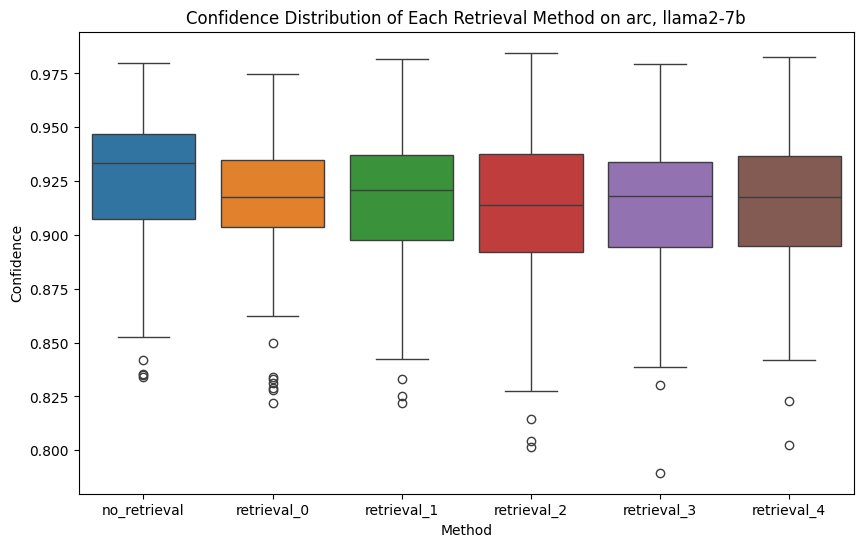

In [61]:
# confdidence distrubution of each prefix: box plot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
cfd_no = []
cfd_0 = []
cfd_1 = []
cfd_2 = []
cfd_3 = []
cfd_4 = []

prefix = ['no_retrieval', 'ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']
answers = []
for item in json_file:
    cfd = [compute_confidence(item[pre + '_log_probs']) for pre in prefix] 
    cfd_no.append(cfd[0])
    cfd_0.append(cfd[1])
    cfd_1.append(cfd[2])
    cfd_2.append(cfd[3])
    cfd_3.append(cfd[4])
    cfd_4.append(cfd[5])

df_cfd = pd.DataFrame({'no_retrieval': cfd_no, 'retrieval_0': cfd_0, 'retrieval_1': cfd_1, 'retrieval_2': cfd_2, 'retrieval_3': cfd_3, 'retrieval_4': cfd_4})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cfd)
plt.ylabel('Confidence')
plt.xlabel('Method')
plt.title(f'Confidence Distribution of Each Retrieval Method on {tasks[choice]}, {model}')
plt.show()

# 4. Self-evaluation RAG analysis on example data

In [62]:
# ablation results
model = 'llama2-7b' # 'llama2-7b', 'llama3-8b' or 'selfrag'
choice = 3

tasks = ['pqa', 'tqa', 'health', 'arc']

if 'llama3' in model:
    res_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}-final_rec_SEnCFD.json'
    auxilary_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}.json'
elif 'llama2' in model:
    res_path = f'minqi_inf_output/llama2chat-{tasks[choice]}-final_rec_SEnCFD.json'
    auxilary_path = f'minqi_inf_output/llama2chat-{tasks[choice]}.json'
elif'selfrag' in model:
    res_path = f'minqi_inf_output/selfrag-{tasks[choice]}-final_rec_SEnCFD.json'
    auxilary_path = f'minqi_inf_output/selfrag-{tasks[choice]}.json'

with open(res_path) as f:
    json_file = json.load(f)

with open(auxilary_path) as f:
    json_file_aux = json.load(f)

df = pd.DataFrame(json_file)
df = df['results']

df_aux = pd.DataFrame(json_file_aux)

metrics

In [63]:
answers = []

prefix = ['no_retrieval', 'ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']

for i in range(len(df['chosen_ans'])):
    cur_ans_prefix = df['chosen_ans'][i]
    cur_ans = df_aux[cur_ans_prefix][i]

    answers.append(cur_ans)

scores = []
golds = df['golds']
for i in range(len(answers)):
    if choice in [0,1]:
        metric = 'loose_match'
        score_ = metric_max_over_ground_truths(loose_match, answers[i], golds[i])
    else:
        metric = 'loose_acc'
        score_ = metric_max_over_ground_truths(loose_acc, answers[i], golds[i])
    scores.append(score_)
print('Resuls for SE RAG: ', model, tasks[choice])
print(f'{metric} {np.mean(scores)*100:.1f}')


Resuls for SE RAG:  llama2-7b arc
loose_acc 53.0


violin plot for SE score distribution

/tmp/ipykernel_2693346/3586489209.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Retrieval Method', y='Score', data=df_melted, palette='pastel')


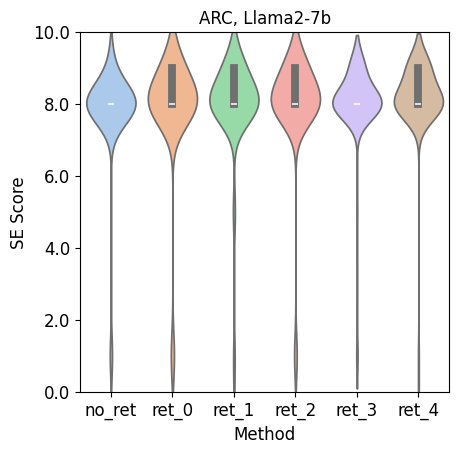

In [64]:
from matplotlib.ticker import FuncFormatter

global_record = df['global_record']
# plot the global record: plot for hist distribution of global record
def get_score(record, i):
    ret = [item[i] for item in record]
    return ret

def one_decimals(x, pos):
    return f'{x:.1f}'

df_se = pd.DataFrame({'no_ret': get_score(global_record, 0), 'ret_0': get_score(global_record, 1), 'ret_1': get_score(global_record, 2), 'ret_2': get_score(global_record, 3), 'ret_3': get_score(global_record, 4), 'ret_4': get_score(global_record, 5)})
df_melted = df_se.melt(var_name='Retrieval Method', value_name='Score')

# Plot
# Plot
plt.figure(figsize=(4.5, 4.5))
sns.violinplot(x='Retrieval Method', y='Score', data=df_melted, palette='pastel')
plt.gca().set_ylim(bottom=0, top=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(one_decimals))
plt.ylabel('SE Score', fontsize=12)
plt.xlabel('Method', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'{tasks[choice].upper()}, {model.capitalize()}', fontsize=12)
plt.subplots_adjust(left=0.17, right=0.99, top=0.91, bottom=0.11)
plt.show()


# 5. Standard RAG (Top retrieval) + No Retrieval

In [77]:
# ablation results
model = 'llama2-7b' # 'llama2-7b', 'llama3-8b' or 'selfrag'
choice = 3
chosen_ret = ['no_retrieval', 'ret_0'] # 'ret_0' or 'no_retrieval'

tasks = ['pqa', 'tqa', 'health', 'arc']

if 'llama3' in model:
    res_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}.json'
elif 'llama2' in model:
    res_path = f'minqi_inf_output/llama2chat-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/llama2chat-{tasks[choice]}.json'
elif'selfrag' in model:
    res_path = f'minqi_inf_output/selfrag-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/selfrag-{tasks[choice]}.json'

with open(res_path) as f:
    json_file = json.load(f)

with open(auxilary_path) as f:
    json_file_aux = json.load(f)

df = pd.DataFrame(json_file)
df = df['results']

df_aux = pd.DataFrame(json_file_aux)

In [80]:
for chosen_ in chosen_ret:
    answers = []
    for i in range(len(df['chosen_ans'])):
        cur_ans_prefix = chosen_
        cur_ans = df_aux[cur_ans_prefix][i]
        answers.append(cur_ans)

    scores = []
    golds = df['golds']
    for i in range(len(answers)):
        if choice in [0,1]:
            metric = 'loose_match'
            score_ = metric_max_over_ground_truths(loose_match, answers[i], golds[i])
        else:
            metric = 'loose_acc'
            score_ = metric_max_over_ground_truths(loose_acc, answers[i], golds[i])
        scores.append(score_)
    print(f'Resuls for {chosen_}:', model, tasks[choice])
    print(f'{metric} {np.mean(scores)*100:.1f}')
    print('='*100)


Resuls for no_retrieval: llama2-7b arc
loose_acc 51.0
Resuls for ret_0: llama2-7b arc
loose_acc 48.0


# 6. S2RAG

In [81]:
# ablation results
model = 'llama2-7b' # 'llama2-7b', 'llama3-8b' or 'selfrag'
choice = 3

tasks = ['pqa', 'tqa', 'health', 'arc']

if 'llama3' in model:
    res_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/llama3Ins-{tasks[choice]}.json'
elif 'llama2' in model:
    res_path = f'minqi_inf_output/llama2chat-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/llama2chat-{tasks[choice]}.json'
elif'selfrag' in model:
    res_path = f'minqi_inf_output/selfrag-{tasks[choice]}-final_rec.json'
    auxilary_path = f'minqi_inf_output/selfrag-{tasks[choice]}.json'

with open(res_path) as f:
    json_file = json.load(f)

with open(auxilary_path) as f:
    json_file_aux = json.load(f)

df = pd.DataFrame(json_file)
df = df['results']

df_aux = pd.DataFrame(json_file_aux)

In [83]:
answers = []

prefix = ['no_retrieval', 'ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']

for i in range(len(df['chosen_ans'])):
    cur_ans_prefix = df['chosen_ans'][i]
    cur_ans = df_aux[cur_ans_prefix][i]

    answers.append(cur_ans)

scores = []
golds = df['golds']
for i in range(len(answers)):
    if choice in [0,1]:
        metric = 'loose_match'
        score_ = metric_max_over_ground_truths(loose_match, answers[i], golds[i])
    else:
        metric = 'loose_acc'
        score_ = metric_max_over_ground_truths(loose_acc, answers[i], golds[i])
    scores.append(score_)
print('Resuls for SE RAG:', model, tasks[choice])
print(f'{metric} {np.mean(scores)*100:.1f}')


Resuls for SE RAG: llama2-7b arc
loose_acc 51.0


# 7. Training Judge